# Tensor Completion

*Completing* a tensor means filling out its missing values. It's the equivalent of interpolation for the case of discretized tensor grids.

In [1]:
import torch
import tntorch as tn
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

We will start by readingd a text image and masking out 90% of its pixels:

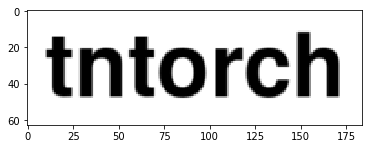

We will keep 1159 out of 11592 pixels


In [2]:
im = torch.DoubleTensor(plt.imread('../images/text.png'))
plt.imshow(im, cmap='gray', vmin=im.min(), vmax=im.max())
plt.show()

P = im.shape[0]*im.shape[1]
Q = int(P/10)
print('We will keep {} out of {} pixels'.format(Q, P))
X = np.unravel_index(np.random.choice(P, Q), im.shape)  # Coordinates of surviving pixels
y = torch.Tensor(im[X])  # Grayscale values of surviving pixels

The masked image looks like this:

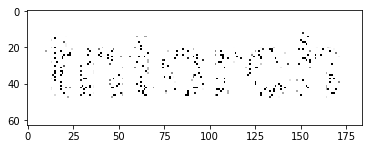

In [3]:
mask = np.ones_like(plt.imread('../images/text.png'))
mask[X] = y
plt.imshow(mask, cmap='gray', vmin=im.min(), vmax=im.max())
plt.show()

Now, we will try to recover the image by completing a rank-6 tensor with those samples:

iter: 0      | loss:   1.118146 | total time:    0.0020
iter: 500    | loss:   0.188934 | total time:    0.5622
iter: 1000   | loss:   0.064226 | total time:    1.0480
iter: 1500   | loss:   0.012528 | total time:    1.5524
iter: 2000   | loss:   0.003347 | total time:    2.0780
iter: 2142   | loss:   0.002464 | total time:    2.2223 <- converged (tol=0.0001)


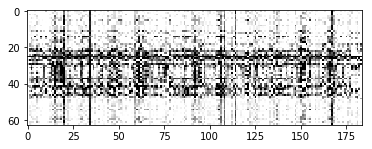

In [4]:
t = tn.rand(im.shape, ranks_tt=6, requires_grad=True)

def loss(t):
    return tn.relative_error(y, t[X])
tn.optimize(t, loss)

plt.imshow(t.numpy(), cmap='gray', vmin=im.min(), vmax=im.max())
plt.show()

The result is not convincing since we are not using any notion of spatial correlation: the real world signal is smooth, but our tensor does not know about it.

## Smoothness Priors

This time we will add a penalization term in the hope of getting a smoother reconstruction. We will use the norm of the tensor's 2nd-order derivatives, for which we can use the function `partialset()`. To combine (add) both losses, we need to return them as a tuple from the `loss()` function:

iter: 0      | loss:   0.939094 +   2.066542 =      1.503 | total time:    0.0075
iter: 500    | loss:   0.105629 +   0.065730 =    0.08568 | total time:    2.5438
iter: 1000   | loss:   0.060540 +   0.016617 =    0.03858 | total time:    5.1190
iter: 1500   | loss:   0.050981 +   0.009464 =    0.03022 | total time:    8.0793
iter: 2000   | loss:   0.041481 +   0.008778 =    0.02513 | total time:   10.9189
iter: 2500   | loss:   0.029073 +   0.008663 =    0.01887 | total time:   13.5404
iter: 3000   | loss:   0.018700 +   0.007371 =    0.01304 | total time:   16.1732
iter: 3500   | loss:   0.012711 +   0.006064 =   0.009387 | total time:   18.7384
iter: 4000   | loss:   0.009467 +   0.005398 =   0.007432 | total time:   21.2740
iter: 4500   | loss:   0.007307 +   0.005133 =    0.00622 | total time:   24.4023
iter: 5000   | loss:   0.005715 +   0.004959 =   0.005337 | total time:   27.6139
iter: 5500   | loss:   0.004675 +   0.004743 =   0.004709 | total time:   30.1785
iter: 6000   | l

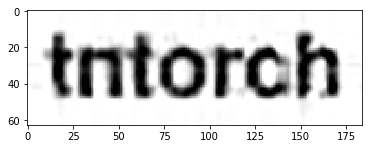

In [5]:
t = tn.rand(im.shape, ranks_tt=6, requires_grad=True)

def loss(t):
    return tn.relative_error(y, t[X])**2, tn.normsq(tn.partialset(t, order=2))*1e-4
tn.optimize(t, loss)

plt.imshow(t.numpy(), cmap='gray', vmin=im.min(), vmax=im.max())
plt.show()

For more details on deriving tensors, check out [this notebook](https://github.com/rballester/tntorch/blob/master/tutorials/derivatives.ipynb).